In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
from pprint import pprint
import json
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from typing import List, Dict, Callable

# plt.style.use('ggplot')
plt.style.use("cyberpunk")

import os
os.getcwd()

'/home/jovyan/work/Fraud_Detection'

In [3]:
# Import Custom Modules
from src.cleaner import *

In [4]:
# Import Data
data = pd.read_json('data/data.json')

In [5]:
# Clean Data
cleaned_data = clean_with_target(data)

# Preview Data
cleaned_data.head(2)

,channels,country,currency,delivery_method,email_domain,fb_published,has_logo,listed,payee_name,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan
0,5,840,840,0.0,gmail.com,0,0,1,,3,1259613950,1,840,25.777471,-80.133433,1,0,36000,370132.0,3125756
1,0,840,840,1.0,ruf.org,0,1,0,RUF,2,1280942776,3,840,32.776566,-79.930922,0,49,32400,625.0,12889894


# Featurize for Visualization / KNN Model

In [6]:
def re_add_features(data:pd.DataFrame, data2:pd.DataFrame) -> pd.DataFrame:
    """ Adds wanted features back from original dataframe """
    res = data.copy()
    from_ = data2.copy()
    
    res['event_created'] = from_['event_created']
    res['event_end'] = from_['event_end']
    res['event_published'] = from_['event_published']
    res['user_created'] = from_['user_created']
    

    return res

def create_features(data:pd.DataFrame) -> pd.DataFrame:
    """ Creates features from given data geared towards KNN Model """
    
    res = data.copy()
    # 'listed' col to binary
    res['listed'] = res['listed'].apply(lambda x: 0 if x == 'y' else 1)
#     # 'previous_payments' to n_previous_payments
#     res['n_previous_payouts'] = res['previous_payouts'].apply(lambda x: len(x))
#     res.drop(columns='previous_payouts', inplace=True)
    # 'country' feature to 'None' instead of nan
    res['country'] = res['country'].fillna('None')
    
    # Durations (create durations between event_created/start/end/publish)
    res['event_duration'] = res['event_end'] - res['event_start']
    res['event_till_publish'] = res['event_published'] - res['event_created']
    res['user_event_lifespan'] = res['event_created'] - res['user_created']
    res.drop(columns=['event_created', 'event_published', 'event_start', 'event_end'], inplace=True)
    
    return res

In [7]:
cleaned_data.head(2)

,channels,country,currency,delivery_method,email_domain,fb_published,has_logo,listed,payee_name,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan
0,5,840,840,0.0,gmail.com,0,0,1,,3,1259613950,1,840,25.777471,-80.133433,1,0,36000,370132.0,3125756
1,0,840,840,1.0,ruf.org,0,1,0,RUF,2,1280942776,3,840,32.776566,-79.930922,0,49,32400,625.0,12889894


# Visualizations

In [8]:
# Global Series to use in Visualizations
fraud = cleaned_data[cleaned_data['fraud'] == 1]
legit = cleaned_data[cleaned_data['fraud'] == 0]
event_groups = cleaned_data.groupby('fraud')

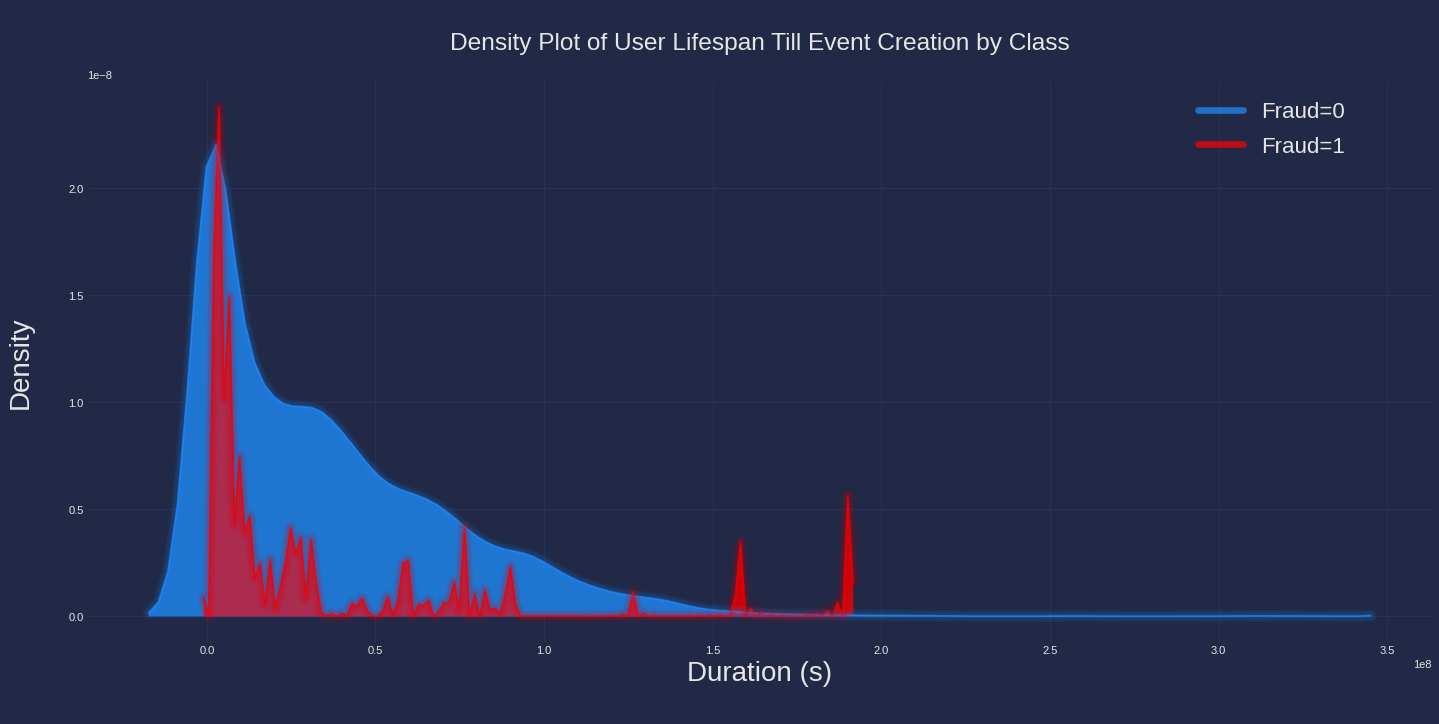

In [9]:
# Create A Fraud vs User to Event Lifespan Dist

# Draw Plot
plt.figure(figsize=(14,7), dpi= 80)

alpha_col = 0.7
colors = ["dodgerblue", "red"]
classification = sorted(cleaned_data["fraud"].unique())

# Plot Points
for col, class_ in zip(colors, classification):
    sns.kdeplot(cleaned_data.loc[cleaned_data['fraud'] == class_, "user_event_lifespan"], shade=True, color=col, label=f"Fraud={class_}", alpha=.7)

# Decoration
plt.title('\nDensity Plot of User Lifespan Till Event Creation by Class\n', fontsize=22)
plt.xlabel("Duration (s)\n", fontsize=25)
plt.ylabel("Density\n", fontsize=25)
legend_ = plt.legend(loc="upper right", bbox_to_anchor=(0.45, 0.5, 0.5, 0.5), fontsize=20, labelspacing=0.6)
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

# Increase Label Line Thickness
for line in legend_.get_lines():
    line.set_linewidth(6)

# Set Limits


# Show Plot
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=1, hspace=0)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


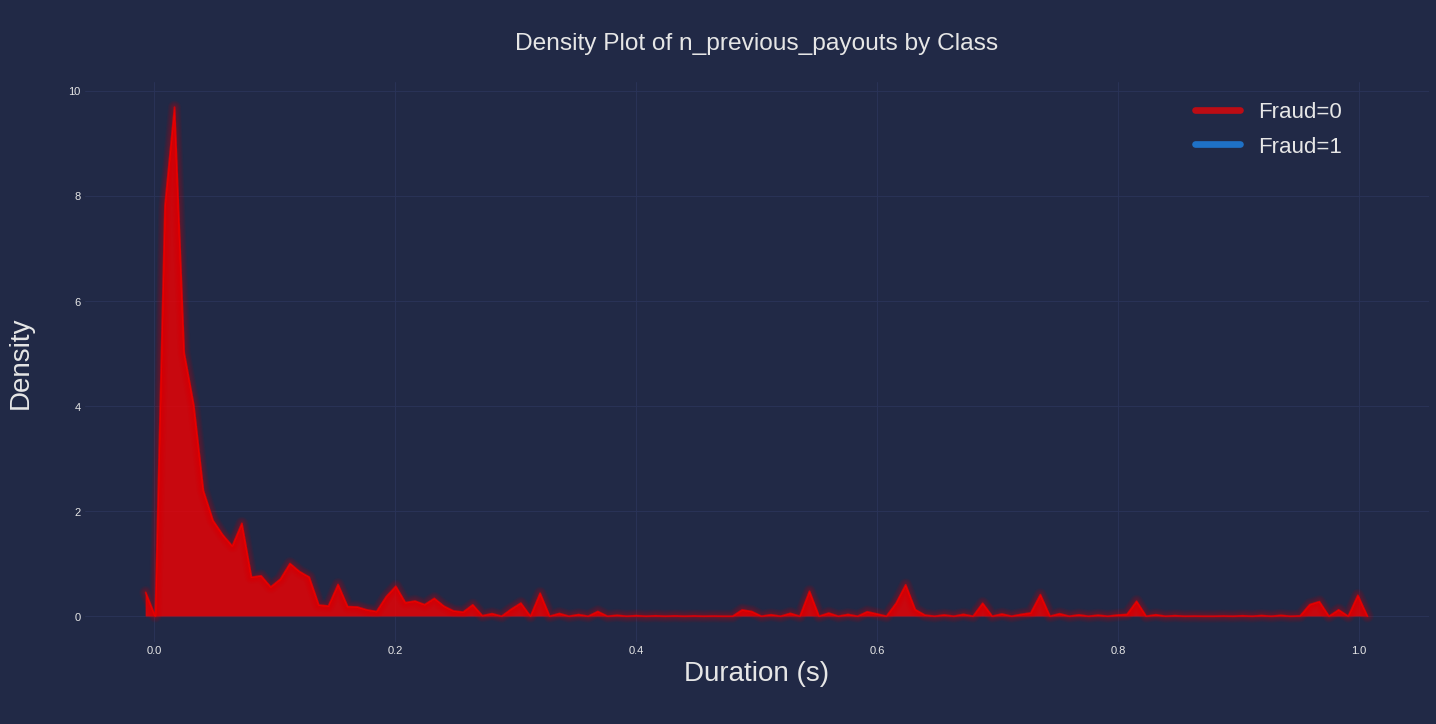

In [10]:
# Create A Fraud vs User to Event Lifespan Dist

# Draw Plot
plt.figure(figsize=(14,7), dpi= 80)

alpha_col = 0.7
colors = ["red", "dodgerblue"]

x = cleaned_data.copy()
x['n_previous_payouts'] = x['n_previous_payouts'].apply(lambda x: x/2048)

# Plot Points
for col, class_ in zip(colors, [0, 1]):
    sns.kdeplot(x.loc[x['fraud'] == class_, "n_previous_payouts"], shade=True, color=col, label=f"Fraud={class_}", alpha=.7)

# Decoration
plt.title('\nDensity Plot of n_previous_payouts by Class\n', fontsize=22)
plt.xlabel("Duration (s)\n", fontsize=25)
plt.ylabel("Density\n", fontsize=25)
legend_ = plt.legend(loc="upper right", bbox_to_anchor=(0.45, 0.5, 0.5, 0.5), fontsize=20, labelspacing=0.6)
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

# Increase Label Line Thickness
for line in legend_.get_lines():
    line.set_linewidth(6)

# Set Limits


# Show Plot
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=1, hspace=0)
plt.show()

# KNN Modeling

In [11]:
# Import KNN Module
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Copy data to avoid collisions
df = clean_with_target(data.copy())

# One Hot Encoding
df = ohe_existence(df, ['email_domain', 'payee_name'])
# df.drop(columns=['venue_latitude', 'venue_longitude'], inplace=True)
df.dropna(inplace=True)

In [12]:
# Create X, y targets
y = df.pop('fraud')
X = df
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
# View All Current NaN Features
for col in df.columns.tolist():
    nas = df[col].isna().sum()
    if nas:
        print(col, nas)

In [14]:
df

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,5,840,840,0.0,0,0,1,3,1259613950,1,840,25.777471,-80.133433,0,36000,370132.0,3125756,1,0
1,0,840,840,1.0,0,1,0,2,1280942776,3,840,32.776566,-79.930922,49,32400,625.0,12889894,1,1
2,8,840,840,1.0,0,0,1,2,1272559388,3,840,33.944201,-118.080419,36,27000,952.0,18531568,1,1
4,11,840,840,0.0,1,0,1,2,1288984065,3,840,42.353848,-71.044276,49,28800,300.0,3010601,1,1
5,6,840,840,0.0,0,1,1,2,1268579110,1,840,38.209797,-84.558831,5,10800,62.0,25842700,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,840,840,0.0,0,1,0,3,1360297993,1,840,39.373780,-76.629921,0,25200,759.0,0,1,0
14333,5,840,840,1.0,0,0,1,2,1241625346,4,840,32.778906,-117.209791,5,10800,3205.0,118741696,1,1
14334,13,-1,840,0.0,1,1,1,1,1353386971,4,840,30.041819,-89.957130,1,21600,736511.0,7213359,1,0
14335,8,840,840,0.0,0,1,1,1,1290204991,3,840,40.862283,-73.911363,128,39600,268.0,70171294,1,0


In [15]:
# Create KNN Model
knn = KNeighborsClassifier(n_neighbors = 10, n_jobs=4)
# Fit KNN Model
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=10, p=2,
                     weights='uniform')

In [16]:
# Y Prediction
y_pred = knn.predict(X_test)
# Score Model
score = knn.score(X_test,y_test)

print(score)

0.9356106408706167


# ROC Curve of KNN Model

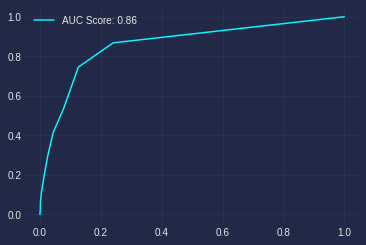

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = knn.predict_proba(X_test)

# Get ROC Curve
auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 2)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:, 1])


plt.plot(fpr, tpr, label=f'AUC Score: {auc}')
         
plt.legend()

# Confusion Matrix

Test Data Accuracy: 0.9356


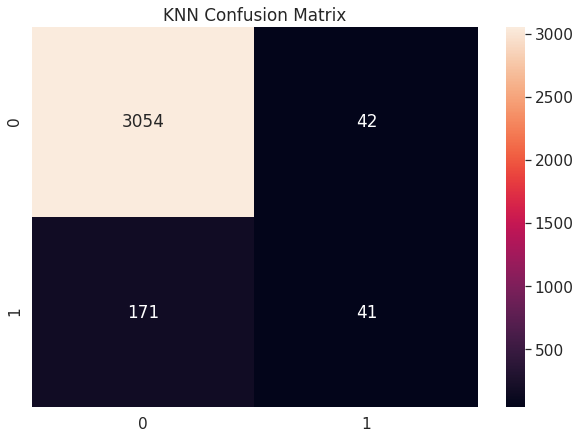

In [18]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score
plt.style.use('ggplot')

cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('KNN Confusion Matrix')


print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# Check API Data

In [19]:
from src.api_client import *

event_api = EventAPIClient()

def _call(client:object) -> pd.DataFrame:
    return client.get_data()

sample_call = _call(event_api)

sample_df = pd.DataFrame(sample_call)
sample_df

,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,sequence_number
0,126,0,GB,GBP,0.0,"<p><img alt="""" width=""608"" height=""901"" /></p>",mariapaviour.com,1361370171,1365883200,1.361372e+09,...,294,1335975660,3,,GB,50.996005,0.189062,"Michel Delving House, Hadlow Down, East Sussex",East Susx,2993


In [20]:
test = clean_row(sample_df, False)
test.fillna(-1, inplace=True)
test.shape, X_test.shape, X_train.shape

((1, 19), (3308, 19), (9921, 19))

In [21]:
# Make prediction on test data
test_pred = knn.predict(test)
# Get probability of prediction
test_proba = knn.predict_proba(test)
# Verify classes
classes = knn.classes_

test_pred, test_proba, classes

(array([0], dtype=int64), array([[1., 0.]]), array([0, 1], dtype=int64))

In [22]:
import pickle

# with open("models/knn_model_v2.pkl", 'wb') as f:
#         pickle.dump(knn, f)